In [1]:
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
import pytket.qasm
from datetime import datetime
import numpy as np
import scipy
import matplotlib.pyplot as plt
from qibo import hamiltonians
from scipy.optimize import minimize
from qibo.symbols import X, Y, Z
from copy import deepcopy

# 1. TLFIM simulation is not affected by layers

Suppose that there is only $\sum XX$ and ignore the $Z$ and $X$ terms.


In [2]:
def XX_interaction(qc, q0, q1, t):
    qc.H(q0), qc.H(q1)
    qc.ZZPhase(t*2/np.pi, q0, q1)
    qc.H(q0), qc.H(q1)

In [6]:
# check if re-ordering XX terms affect the result
t = np.pi/6
nqubits = 4
qc1 = Circuit(nqubits)
XX_interaction(qc1, 0, 1, t)
XX_interaction(qc1, 1, 2, t)
XX_interaction(qc1, 2, 3, t)

qc2 = Circuit(nqubits)
XX_interaction(qc2, 0, 1, t)
XX_interaction(qc2, 2, 3, t)
XX_interaction(qc2, 1, 2, t)

qc3 = Circuit(nqubits)
XX_interaction(qc3, 0, 1, t/2)
XX_interaction(qc3, 2, 3, t/2)
XX_interaction(qc3, 1, 2, t)
XX_interaction(qc3, 0, 1, t/2)
XX_interaction(qc3, 2, 3, t/2)
print(np.linalg.norm(qc1.get_unitary()-qc2.get_unitary()))
print(np.linalg.norm(qc1.get_unitary()-qc3.get_unitary()))

5.087681048627601e-16
2.3102244613642867e-15


Because $[Z_i,Z_{i+1}, Z_{_i+1}Z_{i+2}] = 0$ and $H\cdot H=I$, the TLFIM model is not affected by the $XX$ terms arrangement.

# 2. TLFIM

## 2.1 Test without Rz and Rx

In [35]:
def TLFIM_decomposition(nqubits, t, jx=2, qc=None):
    # This function generates the circuit that simulates e^{itH}
    # where H is the TLFIM model
    # nqubits must be equal or greater than 2
    def generate_adjacent_pairs(n):
        if n < 2:
            raise ValueError("Input nqubits must be equal to or larger than 2.")
        even_starting_pairs = [[s, s+1] for s in range(0, n-1, 2)]
        odd_starting_pairs = [[s, s+1] for s in range(1,n-1, 2)]
        return even_starting_pairs, odd_starting_pairs
    even_starting_pairs, odd_starting_pairs = generate_adjacent_pairs(nqubits)
    if qc is None:
        qc = Circuit(nqubits) 
    for j in range(nqubits):
        # qc.Rz(t*2/np.pi, j)
        # qc.Rx(t*2/np.pi, j)
        qc.H(j)
    for q0, q1 in even_starting_pairs:
        qc.ZZPhase(jx*t*2/np.pi, q0, q1)
    for q0, q1 in odd_starting_pairs:
        qc.ZZPhase(jx*t*2/np.pi, q0, q1)
    for j in range(nqubits):
        qc.H(j)
    return qc

In [36]:
def TLFIM_ref(nqubits, jx, t):
    tlfim_qibo = hamiltonians.SymbolicHamiltonian(
                sum([jx * X(i)*X(i+1) + Z(i) + X(i) for i in range(nqubits-1)]
                + [Z(nqubits-1)+ X(nqubits-1)]))
    return scipy.linalg.expm(-1j*t*tlfim_qibo.matrix)

In [37]:
nqubits = 4
jx = 2
t_space = np.linspace(0, np.pi/6,15)

In [41]:
norms1 = []
norms2 = []
for t in t_space:
    # note that when running this block, TLFIM_decomposition has rz and rx commented out
    tlfim_circ = TLFIM_decomposition(nqubits, t, jx).get_unitary()
    tlfim_xx = scipy.linalg.expm(-1j*t*hamiltonians.SymbolicHamiltonian(sum([jx * X(i)*X(i+1) for i in range(nqubits-1)])).matrix)
    
    # using XX_interactions
    tlfim_xx_tket = Circuit(nqubits)
    for j in range(nqubits-1):
        XX_interaction(tlfim_xx_tket, j, j+1, jx*t)
    norms1.append(np.linalg.norm(tlfim_circ - tlfim_xx))
    norms2.append(np.linalg.norm(tlfim_circ - tlfim_xx_tket.get_unitary()))

[Qibo 0.2.13|WARNING|2025-02-20 21:54:11]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 21:54:11]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 21:54:11]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 21:54:11]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 21:54:11]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 21:54:11]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 21:54:11]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 21:54:11]: Calculating 

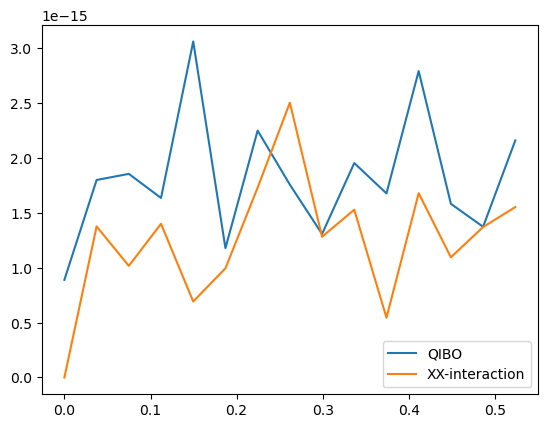

In [42]:
plt.plot(t_space, norms1, label='QIBO')
plt.plot(t_space, norms2, label='XX-interaction')
plt.legend()

## 2.2 TLFIM with Rx

In [50]:
def TLFIM_decomposition(nqubits, t, jx=2, qc=None):
    # This function generates the circuit that simulates e^{itH}
    # where H is the TLFIM model
    # nqubits must be equal or greater than 2
    def generate_adjacent_pairs(n):
        if n < 2:
            raise ValueError("Input nqubits must be equal to or larger than 2.")
        even_starting_pairs = [[s, s+1] for s in range(0, n-1, 2)]
        odd_starting_pairs = [[s, s+1] for s in range(1,n-1, 2)]
        return even_starting_pairs, odd_starting_pairs
    even_starting_pairs, odd_starting_pairs = generate_adjacent_pairs(nqubits)
    if qc is None:
        qc = Circuit(nqubits) 
    for j in range(nqubits):
        # qc.Rz(t*2/np.pi, j)
        qc.Rx(t*2/np.pi, j)
        qc.H(j)
    for q0, q1 in even_starting_pairs:
        qc.ZZPhase(jx*t*2/np.pi, q0, q1)
    for q0, q1 in odd_starting_pairs:
        qc.ZZPhase(jx*t*2/np.pi, q0, q1)
    for j in range(nqubits):
        qc.H(j)
    return qc

In [51]:
norms1 = []
norms2 = []
for t in t_space:
    # note that when running this block, TLFIM_decomposition has rz and rx commented out
    tlfim_circ = TLFIM_decomposition(nqubits, t, jx).get_unitary()
    tlfim_xx = scipy.linalg.expm(-1j*t*hamiltonians.SymbolicHamiltonian(sum([jx * X(i)*X(i+1) + X(i) for i in range(nqubits-1)]+[X(nqubits-1)])).matrix)
    
    # using XX_interactions
    tlfim_xx_tket = Circuit(nqubits)
    for j in range(nqubits-1):
        XX_interaction(tlfim_xx_tket, j, j+1, jx*t)
        tlfim_xx_tket.Rx(t*2/np.pi, j)
    tlfim_xx_tket.Rx( t*2/np.pi, nqubits-1)
    norms1.append(np.linalg.norm(tlfim_circ - tlfim_xx))
    norms2.append(np.linalg.norm(tlfim_circ - tlfim_xx_tket.get_unitary()))

[Qibo 0.2.13|WARNING|2025-02-20 22:05:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:05:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:05:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:05:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:05:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:05:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:05:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:05:59]: Calculating 

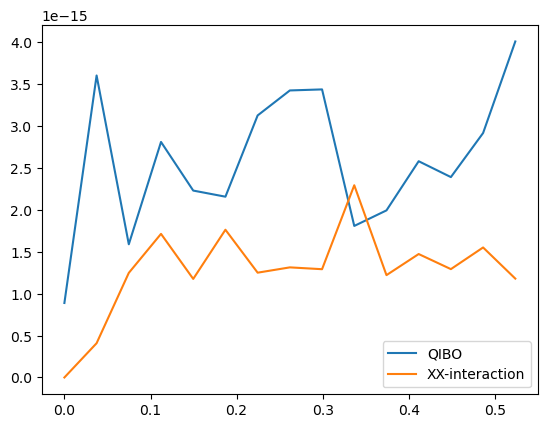

In [ ]:
plt.plot(t_space, norms1, label='QIBO')
plt.plot(t_space, norms2, label='XX-X-interaction')
plt.legend()

## 2.3 TLFIM with Rx and Rz

In [53]:
def TLFIM_decomposition(nqubits, t, jx=2, qc=None):
    # This function generates the circuit that simulates e^{itH}
    # where H is the TLFIM model
    # nqubits must be equal or greater than 2
    def generate_adjacent_pairs(n):
        if n < 2:
            raise ValueError("Input nqubits must be equal to or larger than 2.")
        even_starting_pairs = [[s, s+1] for s in range(0, n-1, 2)]
        odd_starting_pairs = [[s, s+1] for s in range(1,n-1, 2)]
        return even_starting_pairs, odd_starting_pairs
    even_starting_pairs, odd_starting_pairs = generate_adjacent_pairs(nqubits)
    if qc is None:
        qc = Circuit(nqubits) 
    for j in range(nqubits):
        qc.Rz(t*2/np.pi, j)
        qc.Rx(t*2/np.pi, j)
        qc.H(j)
    for q0, q1 in even_starting_pairs:
        qc.ZZPhase(jx*t*2/np.pi, q0, q1)
    for q0, q1 in odd_starting_pairs:
        qc.ZZPhase(jx*t*2/np.pi, q0, q1)
    for j in range(nqubits):
        qc.H(j)
    return qc

In [54]:
norms1 = []
norms2 = []
for t in t_space:
    # note that when running this block, TLFIM_decomposition has rz and rx commented out
    tlfim_circ = TLFIM_decomposition(nqubits, t, jx).get_unitary()
    tlfim_xx = scipy.linalg.expm(-1j*t*hamiltonians.SymbolicHamiltonian(sum([jx * X(i)*X(i+1) + X(i) + Z(i) for i in range(nqubits-1)]+[X(nqubits-1)+Z(nqubits-1)])).matrix)
    
    # using XX_interactions
    tlfim_xx_tket = Circuit(nqubits)
    for j in range(nqubits-1):
        XX_interaction(tlfim_xx_tket, j, j+1, jx*t)
        tlfim_xx_tket.Rx(t*2/np.pi, j)
        tlfim_xx_tket.Rz(t*2/np.pi, j)
    tlfim_xx_tket.Rx( t*2/np.pi, nqubits-1)
    tlfim_xx_tket.Rz( t*2/np.pi, nqubits-1)
    norms1.append(np.linalg.norm(tlfim_circ - tlfim_xx))
    norms2.append(np.linalg.norm(tlfim_circ - tlfim_xx_tket.get_unitary()))

[Qibo 0.2.13|WARNING|2025-02-20 22:07:13]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:07:13]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:07:13]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:07:13]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:07:13]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:07:13]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:07:13]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:07:13]: Calculating 

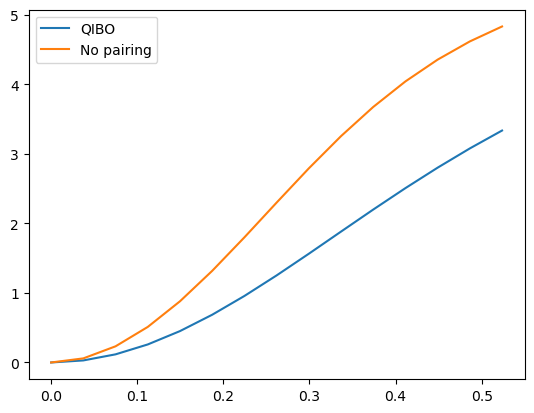

In [56]:
plt.plot(t_space, norms1, label='QIBO')
plt.plot(t_space, norms2, label='No pairing')
plt.legend()

## 2.4 Symmetric second order

$$
e^{-it(\sum XX+\sum X + \sum Z)}\approx e^{-i\frac{t}{2}(\sum Z +\sum X)}e^{-it\sum XX} e^{-i\frac{t}{2}(\sum Z +\sum X)}
$$

In [60]:
def TLFIM_decomposition(nqubits, t, jx=2, qc=None):
    # This function generates the circuit that simulates e^{itH}
    # where H is the TLFIM model
    # nqubits must be equal or greater than 2
    def generate_adjacent_pairs(n):
        if n < 2:
            raise ValueError("Input nqubits must be equal to or larger than 2.")
        even_starting_pairs = [[s, s+1] for s in range(0, n-1, 2)]
        odd_starting_pairs = [[s, s+1] for s in range(1,n-1, 2)]
        return even_starting_pairs, odd_starting_pairs
    even_starting_pairs, odd_starting_pairs = generate_adjacent_pairs(nqubits)
    if qc is None:
        qc = Circuit(nqubits) 
    for j in range(nqubits):
        qc.Rz(t/np.pi, j)
        qc.Rx(t/np.pi, j)
        qc.H(j)
    for q0, q1 in even_starting_pairs:
        qc.ZZPhase(jx*t*2/np.pi, q0, q1)
    for q0, q1 in odd_starting_pairs:
        qc.ZZPhase(jx*t*2/np.pi, q0, q1)
    for j in range(nqubits):
        qc.H(j)
    for j in range(nqubits):
        qc.Rz(t/np.pi, j)
        qc.Rx(t/np.pi, j)
    return qc

In [61]:
norms3 = []
for t in t_space:
    # note that when running this block, TLFIM_decomposition has rz and rx commented out
    tlfim_circ = TLFIM_decomposition(nqubits, t, jx).get_unitary()
    tlfim_xx = scipy.linalg.expm(-1j*t*hamiltonians.SymbolicHamiltonian(sum([jx * X(i)*X(i+1) + X(i) + Z(i) for i in range(nqubits-1)]+[X(nqubits-1)+Z(nqubits-1)])).matrix)
    norms3.append(np.linalg.norm(tlfim_circ - tlfim_xx))

[Qibo 0.2.13|WARNING|2025-02-20 22:27:36]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:27:36]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:27:36]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:27:36]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:27:36]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:27:36]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:27:36]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-20 22:27:36]: Calculating 

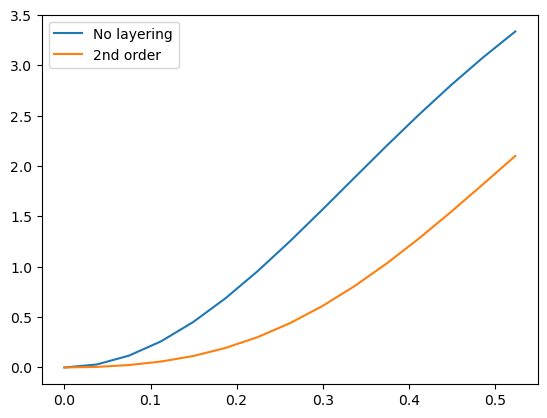

In [62]:
plt.plot(t_space, norms1, label='No layering')
plt.plot(t_space, norms3, label='2nd order')
plt.legend()